<a href="https://colab.research.google.com/github/JeroenJacques/filopodia3D_UNet/blob/main/3D_Unet_filopodia_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D unet for filopodia segementation: reproducibility project**

This is the reproducibility project for the TU Delft Deep Learning course (CS4240). 


**Reproduced paper:** [3-D quantification of filopodia in motile cancer cells](https://ieeexplore.ieee.org/document/8482350/) 

**Authors:** Carlos Castilla, Martin Maska, Dmitry V Sorokin, Erik Meijering, Carlos Ortiz-de-Solorzano

**Reproduced by:** Sander Goossens and Jeroen Jacques

**Supervisor:** Casper van Engelenburg



[Data availability](https://ieee-dataport.org/documents/datasets-used-3-d-quantification-filopodia-motile-cancer-cells-ieee-transactions-medical) 

# A 3D U-Net for segmenting filopodia

The majority of the data analysis in biology relies on the ability to properly segment objects of interest from the background, such as cells, organelles, or even single particles like proteins. A precise image segmentation tool is therefore absolutely crucial. There exist many different approaches for biological-image segmentation such as simple algorithms that rely on thresholding and edge detection to more complicated approaches like shape recognition and hysteresis thresholding. For a nice overview of different segmentation approaches, check out [this paper](https://www.nature.com/articles/nmeth.4473). In this paper one can read that a good segmentation (and tracking) algorithm is not only able to segment the signal as accurately as possible, but is also generalizable to other data that is acquired in a similar way. Deep learning is an upcoming approach for biomedical image segmentation, because it can approach the ground truth pretty well and is also generalizable to more data.

A paper that had a big impact on how image analysis in biology is done is the U-Net paper by [Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597). This CNN consists of an encoder part of sequential convolutional and max pooling layers, and a decoder part of transpose layers to end up with a binary prediction of the learned classes of an input image. There exists many adaptations of the U-Net like the 3D U-Net by [Cicek et al. (2016)](https://arxiv.org/abs/1606.06650) that enables the segmentation of three dimensional data. The paper we tried to reproduce is an implementation of this 3D U-Net for the quantification of filopodia in 3D confocal data by [Castilla et al. (2017)](https://pubmed.ncbi.nlm.nih.gov/30296215/) (and [this](https://ieeexplore.ieee.org/document/8363605) corresponding paper).


#What are filopodia?

Filopodia are short actin based membrane protrusions of around 200 to 300 nm in diameter and occasionally exceed a few micron in length. The image below is a micrograph of HeLa cell (blue =  nuclear staining with dapi; red = actin staining with phalloidn). All the thin filaments radiating out of the cell body are filopodia.

These little protrusions are associated with many cellular tasks, like intercellular communication and cell migration. Therefore, quantifying the filopodia outgrowth can tell many things about the working of the cell.

However, the analysis of filopodia is not an easy task, because of their size and the lack of proper biomarkers. They have to be found by morphpological analysis often based on a segmantation of an actin skeleton staining. However, the filopodia signal can be easily lost due to undersegmentation or oversegmentation. 
Deep learning approaches, like the one implemented here, can therefore help with the analysis and quantification of these small structures.

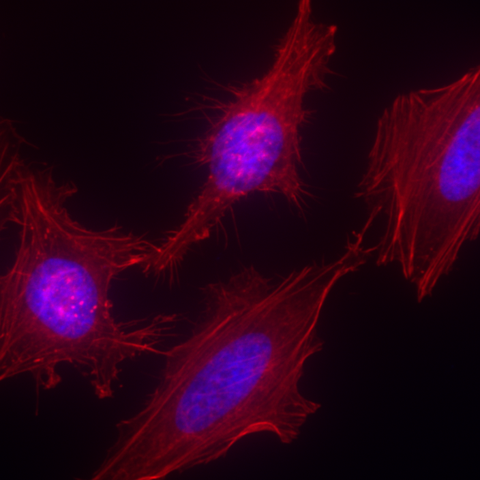

(Image is our own)

In [ ]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import random
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from time import perf_counter

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

!pip install elasticdeform
import elasticdeform.torch as etorch
import elasticdeform

#Data availability and comparison to original data

The authors trained and tested their network on a combination of real microscopy and synthetic data. The real dataset consists of 3D+t images of lung adenocarcinoma cells in a gel, recorded with a spinning disc confocal microscope. From each cell multiple time frames were recorded. Cells with three different phenotypes were included in the data set: wild type cells (WT), cells overexpressing CRMP-2, a protein involved in microtubule formation (OE), and cells a phospho-defective form of CRMP-2 (PD). As can be seen below, the three different cell types have different degrees of filopodia outgrowth with different lengths. 

The synthetic data was produced with [FiloGen](https://cbia.fi.muni.cz/research/simulations/filogen.html), a model-based generator that mimics the three different cell types in the real data set. 

The data sets were made publically available together with the results obtained from their U-Net. However, the ground truth labels were missing. We found [another synthetic dataset](https://bbbc.broadinstitute.org/BBBC046) generated using FiloGen, which is probably the same as used by Castilla et al.. This data set, however, does contain ground truth labels, thus we decided to use this data for our training and testing.

(Images shown below are taken by the latter data set).



In [ ]:
#@title Examples of projections of WT, OE, and PD phenotype cells with their projected targets

%%html
<iframe src="https://drive.google.com/file/d/1YKo9j-Zchv3U_4XRRZPgqc3Jmgk84f5e/preview" width="150" height="170"></iframe>
<iframe src="https://drive.google.com/file/d/1oAQtS4VM488bJT8Fbv2Hm4EVF_UuB8ss/preview" width="150" height="170"></iframe>

<iframe src="https://drive.google.com/file/d/17oH5KgNI0KWqtJ4hAHKZgy1aptIU8zdZ/preview" width="150" height="170"></iframe>
<iframe src="https://drive.google.com/file/d/184Shuc2V8KPz3zcsRYTRDbcG2C-S2z_I/preview" width="150" height="170"></iframe>

<iframe src="https://drive.google.com/file/d/12uU6YwMcijoszkwN5Re5P-HJ2-TSG-x4/preview" width="200" height="170"></iframe>
<iframe src="https://drive.google.com/file/d/1uoffXmNdfm9KOvmb6j_FABnX7FtoynG3/preview" width="200" height="170"></iframe>

The data of all three phenotypes and their labels were downloaded and ordered into an */img* folder and a */label* folder. To make the data loading easier, the names of all 900+ images were changed into a number in MATLAB. The labels had the same number as their matching image.

```
files = dir('*.tif');
startnum = 0;

for i=1:length(files)
    [~, f] = fileparts(files(i).name);
    movefile(files(i).name, sprintf('%d.tif', i+startnum));  
end
```

The ordered data set was uploaded to the google cloud, which could then we be linked to google colab.



In [ ]:
#@title Link Colab to Google Cloud
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash
!gcloud init
!gsutil -m cp -r gs://filodata3d/data_set .

# Build data loader

## Data Augmentation
A common issue with biomedical data is that they are often expensive to generate and therefore, data sets tend to be small. The reasons that DL models can still be trained properly on this data is thanks to extensive data augmentation and the fact that these images often contain highly repetitive structures. 

The data augmentation used in the original U-Net is a combination of elastic deformation and random rotation. For the elastic deformation we used a the [elasticdeformation package](https://github.com/gvtulder/elasticdeform) (`etorch.deform_grid()`). For the random rotation we used the `torchvision.transforms.RandomRotation()`. Both augmentations were applied to all Z-sliced and displacements/ratation to each input-target pair.

We implemented this, however, we ran into the problem that the values in the label images get disorganized. Therefore, we assumened the result would be better if we did not apply the augmentation, taken into consideration that our dataset contained 900 images.

## Data loader
the synthetic dataset of FiloGen contained a total of 900 images, consisting of 30 cells of the 3 different phenotypes, 30 timeframes per cell. Below we show two animations: the left animation goes through all the z-stack, while the right animation is a timelapse of a z-projected smaple.

The original 3D images had variable sizes (x,y,z). We rescaled this to the expected input size of the model, 132 x 132 x 124, so that they all have the same dimension for the model training. Since the model does not use padding, the size of the output is reduced because border pixels are lost. As a result, the output images have a size of 44 x 44 x 36, we rescaled the labels to this size using (`F.interpolate()`).

In the ground truth labels, the background has a value of 0, the cellbody a value of 50 and each filopodia is labeled with a multiple of 100. We revalued this using `torch.where()`, due to the interpolation the borders might be smoothen out, to make the revaluation more robust we set all values below 30 to 0 (i.e. Background), all values between 30 and 70 to 1 (i.e. Cell-body) and all values above 70 to 2 (i.e. Filopodia).

(Run the following cell if the animations do not play)

In [ ]:
#@title Animated gifs of stacks of and image (left) and time-lapse of different time frames (right)
%%html
<iframe src="https://drive.google.com/file/d/1g9kcjkmKQvPaFqTPg8TIPmZNO9YpPWWw/preview" width="500" height="300"></iframe>
<iframe src="https://drive.google.com/file/d/1jbyW1_AADVJnKbkB-A9nLWwndGV8FRgK/preview" width="250" height="300"></iframe>


In [ ]:
def edeform(input, target):
  """
      Applies random 3D elastic deformation & Random Rotation on the input and the target and 
      returns deformed input, output.

          input:  3D tensor of input image. With shape [x, y, z].
          target: 3D target tensor corresponding to the output Neural 
                  network model. With shape [x, y, z]  
  """

  # Initialize random deformation
  displacement_val = np.random.randn(2, 3, 3) * 5
  displacement = torch.tensor(displacement_val)

  # Deform input and target --> ADD ROTATION
  input_deformed1 = etorch.deform_grid(input, displacement, order=3, axis=(0, 1))
  target_deformed1 = etorch.deform_grid(target, displacement, order=3, axis=(0, 1))

  # Random Rotation between [0-360] degree
  deg = random.uniform(0,360)
  rotate = transforms.Compose([transforms.RandomRotation((deg,deg))])

  input_deformed1 = rotate(input_deformed1)
  target_deformed1 = rotate(target_deformed1)

  return input_deformed1, target_deformed1


def load_dataset(T, num_load, device='cpu'):

  '''
    Initialize loader for the training data and ground truth data
    List of data input containing tuples (input, label), input is 5D tensor, label is 4D tensor
    T = 'Train' or 'Test'
    device = 'cpu' or 'gpu'
  '''

  train_loader = []

  truth_path = 'data_set/label'
  input_path = 'data_set/img'
  fol_l = len(os.listdir(input_path))

  transform_totens = transforms.Compose([transforms.ToTensor()])

  # loop through entire data folder
  for i in range(num_load): 
    
    file_nr = random.randint(0, fol_l)

    target = Image.open(truth_path + '/' + str(i) + '.tif')
    input = Image.open(input_path + '/' + str(i) + '.tif')

    width, height = input.size
    depth = input.n_frames

    # initialize placeholder tensors for input an target stacks
    in_t = torch.zeros([height, width, depth], dtype = torch.float64)
    tar_t = torch.zeros([height, width, depth], dtype = torch.float64)

    # initialize placeholders for output images and targets
    input_3D = torch.zeros([1, 1, 132, 132, 124], dtype = torch.float64) #dtype int16 /
    temp = torch.zeros([1, 1, 44, 44, 36], dtype = torch.float64)
    target_3D = torch.zeros([1, 44, 44, 36], dtype = torch.float64)

    for j in range(depth): 
      
      input.seek(j)                      
      target.seek(j)
      in_t[ :, :, j] = transform_totens(input)
      tar_t[:, :, j] = transform_totens(target)
    
    in_t = in_t.unsqueeze(0).unsqueeze(0)
    tar_t = tar_t.unsqueeze(0).unsqueeze(0)  

    input_3D = F.interpolate(in_t, size = [132, 132, 124])
    temp = F.interpolate(tar_t, size = [44, 44, 36])

    # 0 = Background
    target_3D[0, :,:,:] = torch.where(temp <= 30, 0, 0)
    # 1 = Cell body
    target_3D[0, :,:,:] = torch.where(torch.logical_and(temp > 30, temp<70), 1, target_3D.long())
    # 2 = Filopodia
    target_3D[0, :,:,:] = torch.where(temp >= 70, 2, target_3D.long())
    
    if device == 'gpu':
      input3D = input3D.cuda()
      target3D = target3D.cuda()

    train_loader.append((input_3D, target_3D))

  return train_loader

def show_dataset(dataset, grayscale=True):
    """
        This function allows one to check if the data is loaded correctly. It will display three random samples form the set.
    """
    if grayscale:
        cmap = 'Greys_r'
    else:
        cmap = None

    plt.figure(figsize=(40, 3))
    for i in range(1, 6, 2):
        rand_idx = random.randrange(len(dataset))
        for j in range(0, 2):
            plt.subplot(1, 6, i + j)

            if j == 0:
              _,_,_,_,z = dataset[rand_idx][j].size()
              tensor = dataset[rand_idx][j][0,0,:,:,z//2]
              plt.title('Input')           

            elif j == 1:
              _,_,_,z = dataset[rand_idx][j].size()
              tensor = dataset[rand_idx][j][0,:,:,z//2]
              plt.title('Target')

            plt.imshow(tensor, cmap=cmap, aspect='equal')
            plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
            plt.axis('off')

    plt.show()


## Plot Images:
The iamges below show the middle z-slice of 3 random image pairs taken from the generated `train_laoder`.

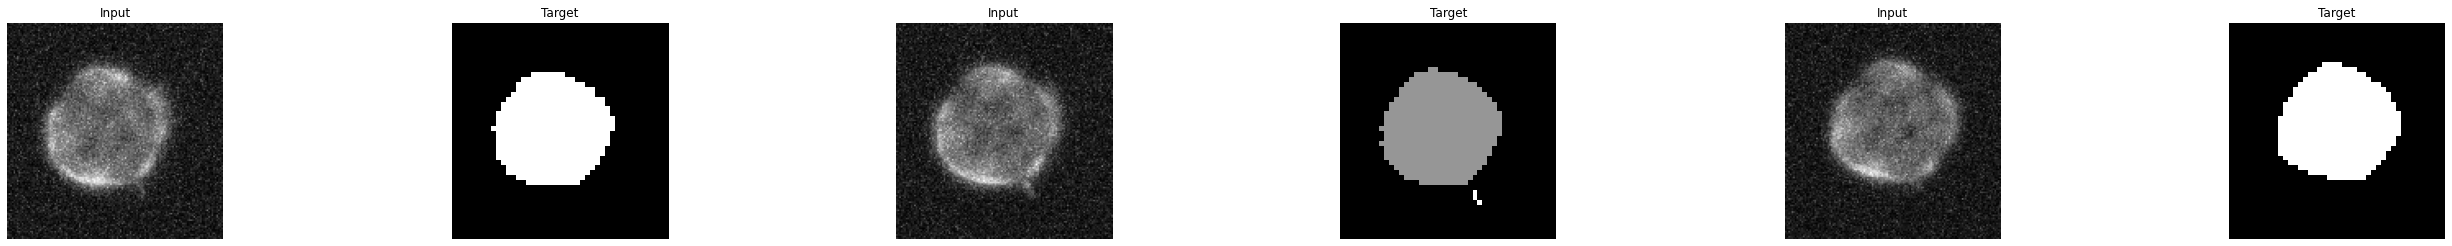

In [ ]:
data = load_dataset('Train', 10)
show_dataset(data)

# Model Implementation
##Short summary of network architecture
The network that was used is a 3D-unet, an extension of the original Unet. 3D-unet is a convolutional network consisting of 3 parts: contraction (also: downconvolution), bottleneck, and expansion (also: upconvolution). 

The input image is processed in four convolutional layers consisting of 32–64, 64–128, 128–256, 256–512 feature maps, followed by 512–256–256, 256–128–128, 128–64–64 feature maps in upconvolution (see image below). Each convolution layer is followed by a ReLU activation and a batch normalization layer.

### Down Convolution (Encoder)
...


### Up convolution (Decoder)
The key characteristic of (3D-) Unet is the concatenation of the feature maps in the upconvolution with the feature maps of the corresponding downconvolutions. This ensures the positional informations of the original image is maintained. After each concatenation a 3D transpose and batch normalization is done. 

The final layer consists of a fully connected layer, outputting 3 channels.


## Implementation
The setup of the model is quite easily done in Pytorch by initializing an `nn.Module`. Pytorch already has all the 3 dimensional layers built in: convolution(`nn.Conv3d`), batch normalization (`nn.BatchNorm3d`), maxpooling (`nn.maxpool2x2x2`), and transpose (`nn.ConvTranspose3d`). 

We define a `double_conv` function for the encoder part of the U-Net that sequentially does a convolution, batch normalization and ReLU activation on the input. After each `double_conv` we maxpool the input and cache the input that will be used later in the decoder part for concateanation. To allow this concatenation, the two inputs should have the same shape. We define the `crop_img` function that crops the cached input to the right dimensions to not run in any troubles.

After 4 `double_conv`'s, the input up-convoluted and transposed three times. A final convolution gives the final output.

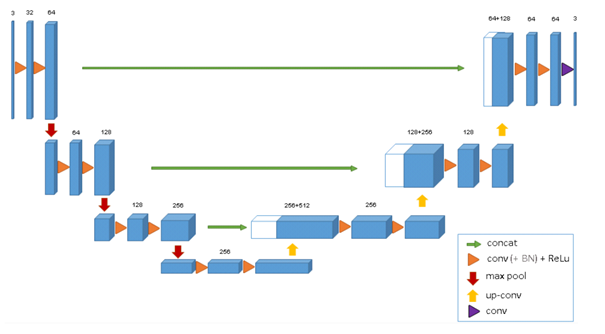


In [ ]:
# Functions for CNN architecture
# Double convolution
def double_conv (in_c, step_c, out_c):
  conv = nn.Sequential(
          nn.Conv3d(in_c, step_c, kernel_size=3),
          nn.BatchNorm3d(step_c),
          nn.ReLU(),
          nn.Conv3d(step_c, out_c, kernel_size=3),
          nn.BatchNorm3d(out_c),
          nn.ReLU()
        )
  return conv

# Crop input for concatenation
def crop_img(tensor, target_tensor):

  target_size_xy = target_tensor.size()[2]
  tensor_size_xy = tensor.size()[2]
  delta_xy = tensor_size_xy - target_size_xy
  delta_xy = delta_xy // 2

  target_size_z = target_tensor.size()[4]
  tensor_size_z = tensor.size()[4]
  delta_z = tensor_size_z - target_size_z
  delta_z = delta_z // 2

  return tensor[:, :, delta_xy:tensor_size_xy-delta_xy, delta_xy:tensor_size_xy-delta_xy, delta_z:tensor_size_z-delta_z]



# 3D unet architecture
class Unet3D(nn.Module):
  ''' 3DUnet; input [1, 1, 132, 132, 124] ; return [1, 44, 44, 36]'''
  def __init__(self):
        super(Unet3D, self).__init__()

        self.max_pool_2x2x2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.down_conv1 = double_conv(1, 32, 64)
        self.down_conv2 = double_conv(64, 64, 128)
        self.down_conv3 = double_conv(128, 128, 256)
        self.down_conv4 = double_conv(256, 256, 512)

        self.up_trans1 = nn.ConvTranspose3d(512, 512, kernel_size=2, stride=2)
        self.up_trans2 = nn.ConvTranspose3d(256, 256, kernel_size=2, stride=2)
        self.up_trans3 = nn.ConvTranspose3d(128, 128, kernel_size=2, stride=2)

        self.up_conv1 = double_conv(768, 256, 256)
        self.up_conv2 = double_conv(384, 128, 128)
        self.up_conv3 = double_conv(192, 64, 64)

        self.final_conv = nn.Conv3d(64, 3, kernel_size=1)

  def forward(self, x):
        # Encoder
        x1 = self.down_conv1(x)
        x = self.max_pool_2x2x2(x1)
        x2 = self.down_conv2(x)
        x = self.max_pool_2x2x2(x2)
        x3 = self.down_conv3(x)
        x = self.max_pool_2x2x2(x3)
        x = self.down_conv4(x)

        # Decoder
        x = self.up_trans1(x)
        y1 = crop_img(x3, x)
        x = self.up_conv1(torch.cat([x, y1], 1))

        x = self.up_trans2(x)
        y2 = crop_img(x2, x)
        x = self.up_conv2(torch.cat([x, y2], 1))

        x = self.up_trans3(x)
        y3 = crop_img(x1, x)
        x = self.up_conv3(torch.cat([x, y3], 1))
        x = self.final_conv(x)

        return x

  def train(self, train_loader, optimizer, criterion):
      """
      Trains network for one epoch in batches.
      Args:
          train_loader: Data loader for training set.
          model: Neural network model.
          optimizer: Optimizer (e.g. SGD).
          criterion: Loss function (e.g. cross-entropy loss).
      """
      avg_loss = 0
      correct = 0
      total = 0 

      n = random.randint(0,len(train_loader))
      print('random print: ' + str(n))

      # iterate through batches
      for i, data in enumerate(train_loader):
          input, label = data
          optimizer.zero_grad()       
          # forward + backward + optimize
          output = self.forward(input.float())      
          loss = criterion(output, label.long())
          loss.backward()
          optimizer.step()

          # keep track of loss and accuracy
          avg_loss += loss
          _, predicted = torch.max(output.data, 1)
          total += label.size(0)
          correct += (predicted == label).sum().item()

      acc = 100*correct / (total*len(train_loader))            
      print(str(avg_loss/len(train_loader)))
      print(str(acc))

      return avg_loss/len(train_loader), (acc)


  def test(self, test_loader, criterion ):
 
      avg_loss = 0
      correct = 0
      total = 0 

      for data in test_loader:
        input, label = data
        output = self.forward(input.float())
        loss = criterion(output, label.long())

        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        acc = (predicted == label).sum().item()
        correct += acc

      print('final avg loss: ' + str(avg_loss))
      print('final accuracy: ' + str(correct))


## Network summary
Our 3D Unet architecture has a total of around 19 million parameters. 



In [ ]:
# RUN this to summarize 3D-Unet
network = Unet3D()
summary(network, (1,132,132, 124))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 130, 130, 122]             896
       BatchNorm3d-2    [-1, 32, 130, 130, 122]              64
              ReLU-3    [-1, 32, 130, 130, 122]               0
            Conv3d-4    [-1, 64, 128, 128, 120]          55,360
       BatchNorm3d-5    [-1, 64, 128, 128, 120]             128
              ReLU-6    [-1, 64, 128, 128, 120]               0
         MaxPool3d-7       [-1, 64, 64, 64, 60]               0
            Conv3d-8       [-1, 64, 62, 62, 58]         110,656
       BatchNorm3d-9       [-1, 64, 62, 62, 58]             128
             ReLU-10       [-1, 64, 62, 62, 58]               0
           Conv3d-11      [-1, 128, 60, 60, 56]         221,312
      BatchNorm3d-12      [-1, 128, 60, 60, 56]             256
             ReLU-13      [-1, 128, 60, 60, 56]               0
        MaxPool3d-14      [-1, 128, 30,

# Training - Main
## Loss
To compare the input and labels we use a weighted cross-entropy loss (`nn.CrossEntropyLoss()`). As explained in data-loading, the images were divided into 3 classes: background, cellbody, and filopodia. To improve segmentation such that it’s main focus is to classify the filopodia correctly, a weighted versions of the cross entropy was used. By passing a weight tensor `ws` as an input in the cross entropy loss:`nn.CrossEntropyLoss(weight=ws)`. The weighted loss of the 3 different channels is calculated. So, the loss for channel 1 will be calculated against all pixels in the label with value one.  

Weights per label:
* 3 - Background,
* 60 - Cell-body 
* 200 - Filopodia 


## Optimizer
The model was then optimized use a stochastic gradient descent (SGD) optimizer (`torch.optim.SGD()`) with a learning rate of 0.0001 and momentum of 0.99.
The data was shuffled and 10% of the 3D images was set aside for testing. Each epoch to training data was shuffled again and the average loss and accuracy were stored.




In [ ]:
torch.cuda.empty_cache()

def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

#Main script
def main(test = False):

  # Try using gpu instead of cpu
  device = try_gpu()
  print(device)

  # setup tensorboard writer 
  writer = SummaryWriter()

  #initialize 3D U-Net and parameters
  net = Unet3D()
  net = net.float()

  # Network to device
  net.to(device)

  batch_size = 1
  n_epoch = 20
  lr = 0.0001
  momentum = 0.99

  ws = torch.tensor([3, 60, 200], dtype = torch.float).cuda()
  loss_fun = nn.CrossEntropyLoss(weight=ws)
  optimizer = torch.optim.SGD(net.parameters(), lr, momentum)

  trainloader = load_dataset('Train') 
  random.shuffle(trainloader)
  # 10%?
  split = int(round(1*len(trainloader)))
  train_set = trainloader[:split]
  test_set = trainloader[split:]
  
  losses = []
  accs = []

  for n in tqdm(range(n_epoch)):
    random.shuffle(train_set)
    avg_loss, acc = net.train(train_set, optimizer, loss_fun)
    losses.append(avg_loss)
    accs.append(acc)

    writer.add_scalars("Loss", {'Train': avg_loss}, n)            
    writer.add_scalars('Accuracy',{'Train': acc}, n)

  print('Finished Training')
  writer.flush()
  writer.close()

  fig = plt.figure(figsize=(15,2))
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('Epochs')
  plt.ylabel('Train - Cross Entropy')
  plt.subplot(1, 2, 2)
  plt.plot(accs)
  plt.xlabel('Epochs')
  plt.ylabel('Train - Accuracy')


  if test:
    net.test(test_set, loss_fun)

  return net, losses, acc


tic = time.perf_counter()
net, losses, acc = main()
toc = time.perf_counter()

print("Main execution time: {} seconds".format(toc- tic))


The training results can be visualized with the tensorboard.

In [ ]:
# Open tensorboard

%tensorboard --logdir logs

#Result & Conclusion
We trained the model for 20 epochs with a new random subset of the data at each epoch consisting of 100 images. The training was done with the GPU provided by Google Colab. This took approaximately 2 hours. We were not able to train on the entire data set for each epoch, due to limited memory resources. This could use some optimization.

To save the trained network, run the following command.

In [ ]:
torch.save(net.state_dict(), './model2')

We obtained the following loss and accuracy plots while training the net. It is clear that the loss decreases and the accuracy increases during training.

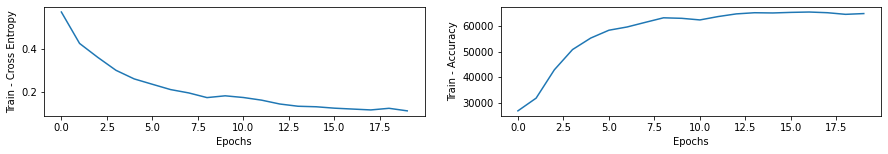

Our pretrained model can be loaded using the following command. Make sure you upload the [trained model](https://drive.google.com/file/d/1cLe3FkIeOQ2iIEHdAHfL-5p5jpu9cTOO/view?usp=sharing) to Colab before.

In [ ]:
the_model = Unet3D()
the_model.load_state_dict(torch.load('./model'))

<All keys matched successfully>

After loading the trained net. The next cell can be run to visualize predictions of the model on some images from the data set.

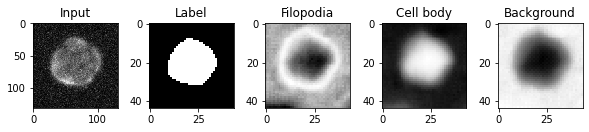

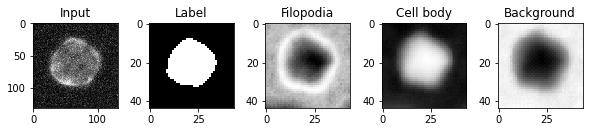

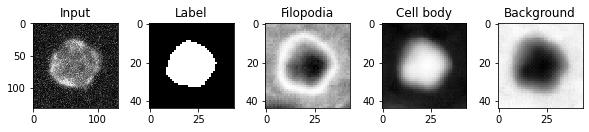

In [ ]:
testloader = load_dataset('Test', 3)

n = len(testloader)


for i, data in enumerate(testloader):

  input, label = data
  out = the_model.forward(input.float())

  plt.figure()
  plt.subplot(n, 5, i*5+1)
  plt.imshow(input[0,0, :, :, 62].cpu(), cmap = 'Greys_r', interpolation="nearest")
  plt.title('Input')    

  plt.subplot(n, 5, i*5+2)
  plt.imshow(label[0, :, :, 18].cpu(), cmap = 'Greys_r', interpolation="nearest")
  plt.title('Label') 

  plt.subplot(n, 5, i*5+3)
  plt.imshow(out[0, 2, :, :, 18].cpu().detach().numpy(), cmap = 'Greys_r', interpolation="nearest")
  plt.title('Filopodia')

  plt.subplot(n, 5, i*5+4)
  plt.imshow(out[0, 1, :, :, 18].cpu().detach().numpy(), cmap = 'Greys_r', interpolation="nearest")
  plt.title('Cell body')

  plt.subplot(n, 5, i*5+5)
  plt.imshow(out[0, 0, :, :, 18].cpu().detach().numpy(), cmap = 'Greys_r', interpolation="nearest")
  plt.title('Background')
  
  plt.subplots_adjust(top=1, bottom=0, left=0.1, right=1.4)

plt.show()


As can be seen, we were not able to properly segmented the filopodia with the 3D-Unet using the synthetic Filogen dataset. We do see that the Background and Cell body is learned to some extent. However the whole cell border is identified as filopodia. 

There could be multiple reasons for our qualitatively lower results. First, the synthetic dataset shows less pronounced filopodia, therefore it is harder to (learn to) identify them. Secondly, it could be that we were not training long enough (i.e. more epochs) or that only using 100 random images per epoch, instead of all 900,  limited the ability of the network to properly learn. Thirdly, our learning could have suffered from the fact that we did not use data augmentation. However, based on our results, it does not seem to overfit on the input images. Finally, it could be that we did not implement the 3D-unet exactly the same way they did. 


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('filopodia.ipynb')

--2021-04-16 19:11:33--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2021-04-16 19:11:33 (35.9 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/


ValueError: ignored